In [1]:
import numpy as np
import random
from functools import partial

from os.path import isfile
import pickle

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import datetime

from albumentations import (Compose, HorizontalFlip, Rotate, OneOf, VerticalFlip, RandomScale)

AUTOTUNE = tf.data.experimental.AUTOTUNE

%load_ext tensorboard

In [2]:
cifar100_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 
    'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 
    'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 
    'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 
    'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 
    'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 
    'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

In [3]:
def view_image(ds):
    image, label = next(iter(ds)) 
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(16, 16))

    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        label_idx = np.argmax(label[i], axis=0)
        ax.set_title(f"Label: {cifar100_labels[label_idx]}")

In [4]:
IMAGE_SHAPE = (224, 224)
def AUG_PROBA(x=0): return random.uniform(0.35, 0.75)
NUM_EPOCHS = 32
BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
NUM_CLASSES = 100
INITIAL_LR = 0.05
DATASET_PERCENT = 5

In [5]:
aug_transforms = Compose([
        OneOf([
                Rotate(limit=15, p=AUG_PROBA()),
                Rotate(limit=45, p=AUG_PROBA()),
                Rotate(limit=90, p=AUG_PROBA())
            ], p=AUG_PROBA()),
        OneOf([
                HorizontalFlip(p=AUG_PROBA()),
                VerticalFlip(p=AUG_PROBA())
            ], p=AUG_PROBA()),
        RandomScale(scale_limit=0.05, p=AUG_PROBA()),
    ]
)

In [6]:
def train_model(model_name: str, model=None, train=None, test=None, tb_logdir='logs/fit/'):
    model_history_fn = "./data/models/" + model_name + "-history.pickle"
    model_fn = './data/models/' + model_name + '-best_model.hdf5'
    ret_model = model

    if isfile(model_history_fn):
        model_history = {}
        
        with open(model_history_fn, "rb") as m_file:
            model_history = pickle.load(m_file)
            
        ret_model = load_model(model_fn, custom_objects={'KerasLayer': hub.KerasLayer})
        
        return model_history, ret_model
    else:
        # Early stop callback
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1)
        
        # Learning rate exp decay
        def lr_exp_decay(epoch, lr):
            k = 0.1
            return INITIAL_LR * np.exp(-k * epoch)

        # Save best model
        checkpoint = ModelCheckpoint(filepath=model_fn,
            monitor='val_loss',
            verbose=1,
            save_best_only=True,
            mode='min'
        )
        
        log_dir = tb_logdir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1)

        model_history = ret_model.fit(
            train, 
            batch_size=BATCH_SIZE, 
            epochs=NUM_EPOCHS,
            validation_data=test,
            validation_batch_size=VAL_BATCH_SIZE,
            callbacks=[early_stop, LearningRateScheduler(lr_exp_decay, verbose=1), checkpoint, tensorboard_callback]
        )
        
        with open(model_history_fn, "wb") as m_file:
            pickle.dump(model_history.history, m_file)

        return model_history.history, ret_model

In [7]:
def get_dataset(ds_name: str, augment=True):
    def aug_fn(image):
        data = {"image": image}
        aug_data = aug_transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.image.resize(aug_img, size=[IMAGE_SHAPE[0], IMAGE_SHAPE[1]])
        return aug_img
    
    def resize_fn(image, label):
        return tf.image.resize(image, size=[IMAGE_SHAPE[0], IMAGE_SHAPE[1]]), label

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label

    def normilize_func(image):
        return tf.cast(image/255.0, tf.float32)

    def normilize_data(image, label):
        image = tf.numpy_function(func=normilize_func, inp=[image], Tout=tf.float32)
        return image, tf.one_hot(label, depth=NUM_CLASSES)

    train_ds, test_ds = tfds.load(
        name=ds_name, 
        split=['train[:{}%]'.format(DATASET_PERCENT), 'test[:{}%]'.format(DATASET_PERCENT)], 
        as_supervised=True, with_info=False, shuffle_files=True
    ) 

    if augment:
        train_ds = train_ds.map(partial(process_data), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
        test_ds = test_ds.map(partial(resize_fn), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
        
    train_ds = train_ds.map(partial(normilize_data), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    test_ds = test_ds.map(partial(normilize_data), num_parallel_calls=AUTOTUNE).batch(VAL_BATCH_SIZE).prefetch(AUTOTUNE)

    return train_ds, test_ds

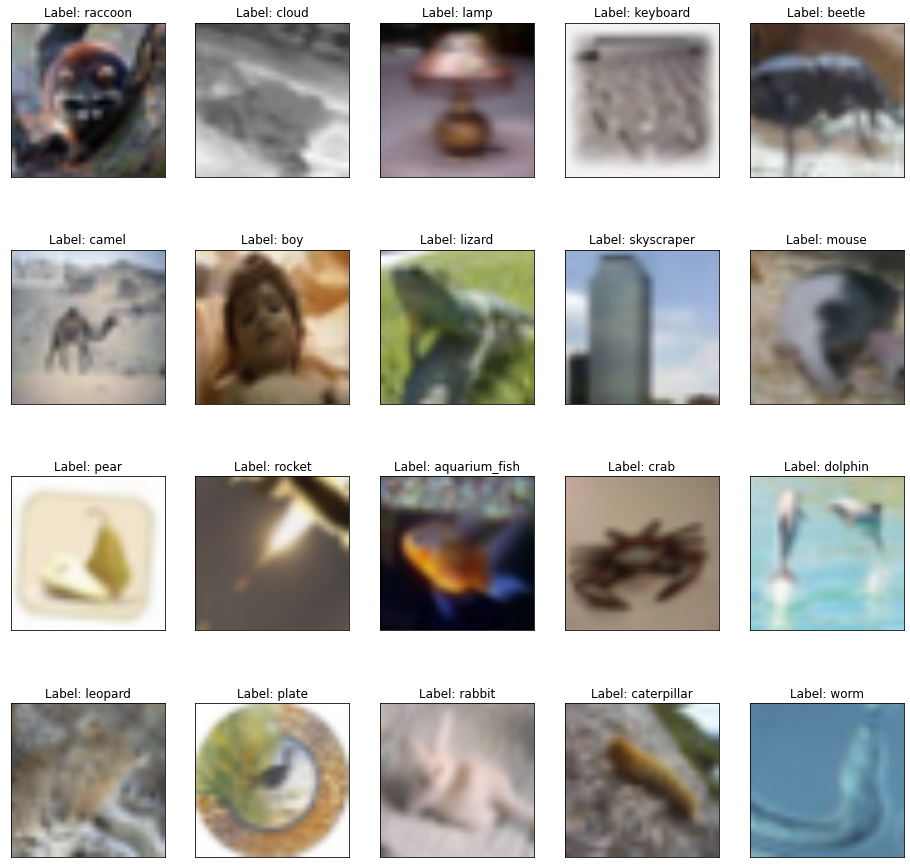

In [8]:
train_ds, test_ds = get_dataset("cifar" + str(NUM_CLASSES), augment=True)
view_image(train_ds)

In [9]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_layer = hub.KerasLayer(
    inception_v3,
    input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3),
    trainable=False)

model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
Total params: 22,007,684
Trainable params: 204,900
Non-trainable params: 21,802,784
_________________________________________________________________


In [10]:
adam_optimizer = Adam(learning_rate=INITIAL_LR)

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history, model_dense = train_model(model_name='dense_output', model=model, train=train_ds, test=test_ds, tb_logdir='logs/fit_dense/')


Epoch 00001: LearningRateScheduler setting learning rate to 0.05.
Epoch 1/32
79/79 [==============================] - ETA: 0s - loss: 80.9187 - accuracy: 0.1100
Epoch 00001: val_loss improved from inf to 32.11607, saving model to ./data/models\dense_output-best_model.hdf5
79/79 [==============================] - 131s 2s/step - loss: 80.9187 - accuracy: 0.1100 - val_loss: 32.1161 - val_accuracy: 0.2380 - lr: 0.0500

Epoch 00002: LearningRateScheduler setting learning rate to 0.04524187090179798.
Epoch 2/32
79/79 [==============================] - ETA: 0s - loss: 26.2308 - accuracy: 0.3136
Epoch 00002: val_loss improved from 32.11607 to 27.83979, saving model to ./data/models\dense_output-best_model.hdf5
79/79 [==============================] - 120s 2s/step - loss: 26.2308 - accuracy: 0.3136 - val_loss: 27.8398 - val_accuracy: 0.2920 - lr: 0.0452

Epoch 00003: LearningRateScheduler setting learning rate to 0.0409365376538991.
Epoch 3/32
79/79 [==============================] - ETA: 0s -

In [11]:
from tensorboard import notebook
notebook.list()
%tensorboard --logdir ./logs/fit_dense/

Known TensorBoard instances:
  - port 6006: logdir ./logs/fit_dense/ (started 1:36:59 ago; pid 16080)
  - port 6006: logdir ./logs/fit_dense/20220116-202839 (started 1:35:48 ago; pid 21336)


Reusing TensorBoard on port 6006 (pid 16080), started 1:36:59 ago. (Use '!kill 16080' to kill it.)